In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/DL_project"

/content/drive/MyDrive/DL_project


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-af59f4b8-b534-2abf-3b6e-a7286bd2ab0a)


In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, Adafactor
import torch

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
data = pd.read_csv("./data/yelp_humor_merged_v1.csv")
# data

In [ ]:
word_cnt_threshold=400
humor_threshold=10

In [ ]:
df = data[(data['word_count'] <= word_cnt_threshold) & ((data['funny']>=humor_threshold) | (data['funny'] == 0))]
# df

In [ ]:
df['humor'].value_counts()

0    491985
1     35901
Name: humor, dtype: int64

In [ ]:
df['funny'].value_counts()

0      491985
10       6128
11       4702
12       3655
13       2954
        ...  
158         1
161         1
162         1
166         1
392         1
Name: funny, Length: 161, dtype: int64

In [ ]:
humor_sample = min(20000, df['humor'].value_counts()[1])
humor_sample

20000

In [ ]:

not_humor_split = 0.5
not_humor_sample = int(humor_sample * (not_humor_split) / (1 - not_humor_split))
not_humor_sample

20000

In [ ]:
df_humor = df[df['humor']==1]
df_humor = df_humor.sample(n=humor_sample, random_state=RANDOM_SEED)
# df_humor

In [ ]:
df_not_humor = df[df['humor']==0]
df_not_humor = df_not_humor.sample(n=not_humor_sample, random_state=RANDOM_SEED)
# df_not_humor

In [ ]:
df = pd.concat([df_humor, df_not_humor])
# df

In [ ]:
class_names = ['not funny', 'funny']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# token_lens = []

# for txt in df.review:
#   tokens = tokenizer.encode(txt, truncation=True)
#   token_lens.append(len(tokens))

In [ ]:
# sns.displot(token_lens)
# plt.xlim([0, 512]);
# plt.xlabel('Token count');

In [ ]:
# (np.array(token_lens) == 512).sum()

In [ ]:
del data, df_humor, df_not_humor #tokens
gc.collect()

711

In [ ]:
MAX_LEN = 512

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.humor, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.humor, random_state=RANDOM_SEED)

In [ ]:
df_train['humor'].value_counts()

1    16000
0    16000
Name: humor, dtype: int64

In [ ]:
df_val['humor'].value_counts()

1    2000
0    2000
Name: humor, dtype: int64

In [ ]:
df_test['humor'].value_counts()

1    2000
0    2000
Name: humor, dtype: int64

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((32000, 8), (4000, 8), (4000, 8))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [ ]:
class HumorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.fc_hidden = nn.Linear(self.bert.config.hidden_size, 1024)
    self.relu = nn.ReLU()
    self.out = nn.Linear(1024, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = self.fc_hidden(pooled_output)
    pooled_output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = HumorClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4777, 0.5223],
        [0.5278, 0.4722],
        [0.5548, 0.4452],
        [0.4871, 0.5129],
        [0.3936, 0.6064],
        [0.4676, 0.5324],
        [0.4836, 0.5164],
        [0.4400, 0.5600]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 2

optimizer = Adafactor(model.parameters(), lr=3e-5, relative_step=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_adafactor.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


Train loss 0.5148407864551992 accuracy 0.7584375
Val   loss 0.44756584173440933 accuracy 0.79925

Epoch 2/2
----------
Train loss 0.4342228913512081 accuracy 0.80784375
Val   loss 0.43832009795308113 accuracy 0.80575

CPU times: user 44min 25s, sys: 25min 52s, total: 1h 10min 17s
Wall time: 1h 10min 8s


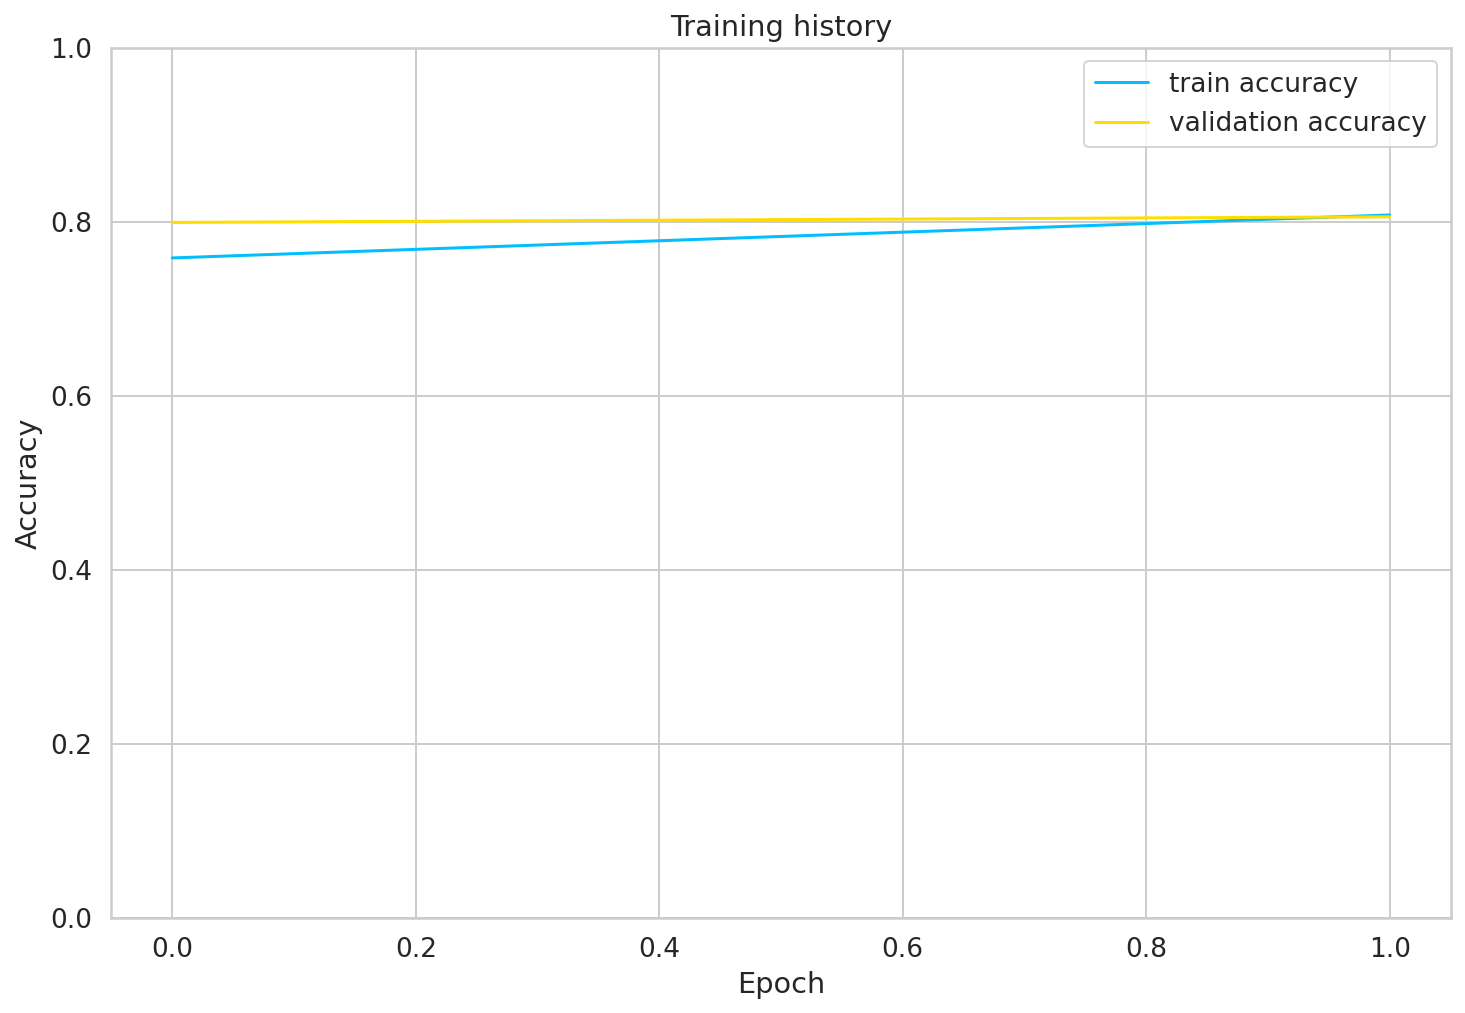

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
model = HumorClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_adafactor.bin'))
model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.81475

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not funny       0.80      0.84      0.82      2000
       funny       0.83      0.79      0.81      2000

    accuracy                           0.81      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.82      0.81      0.81      4000



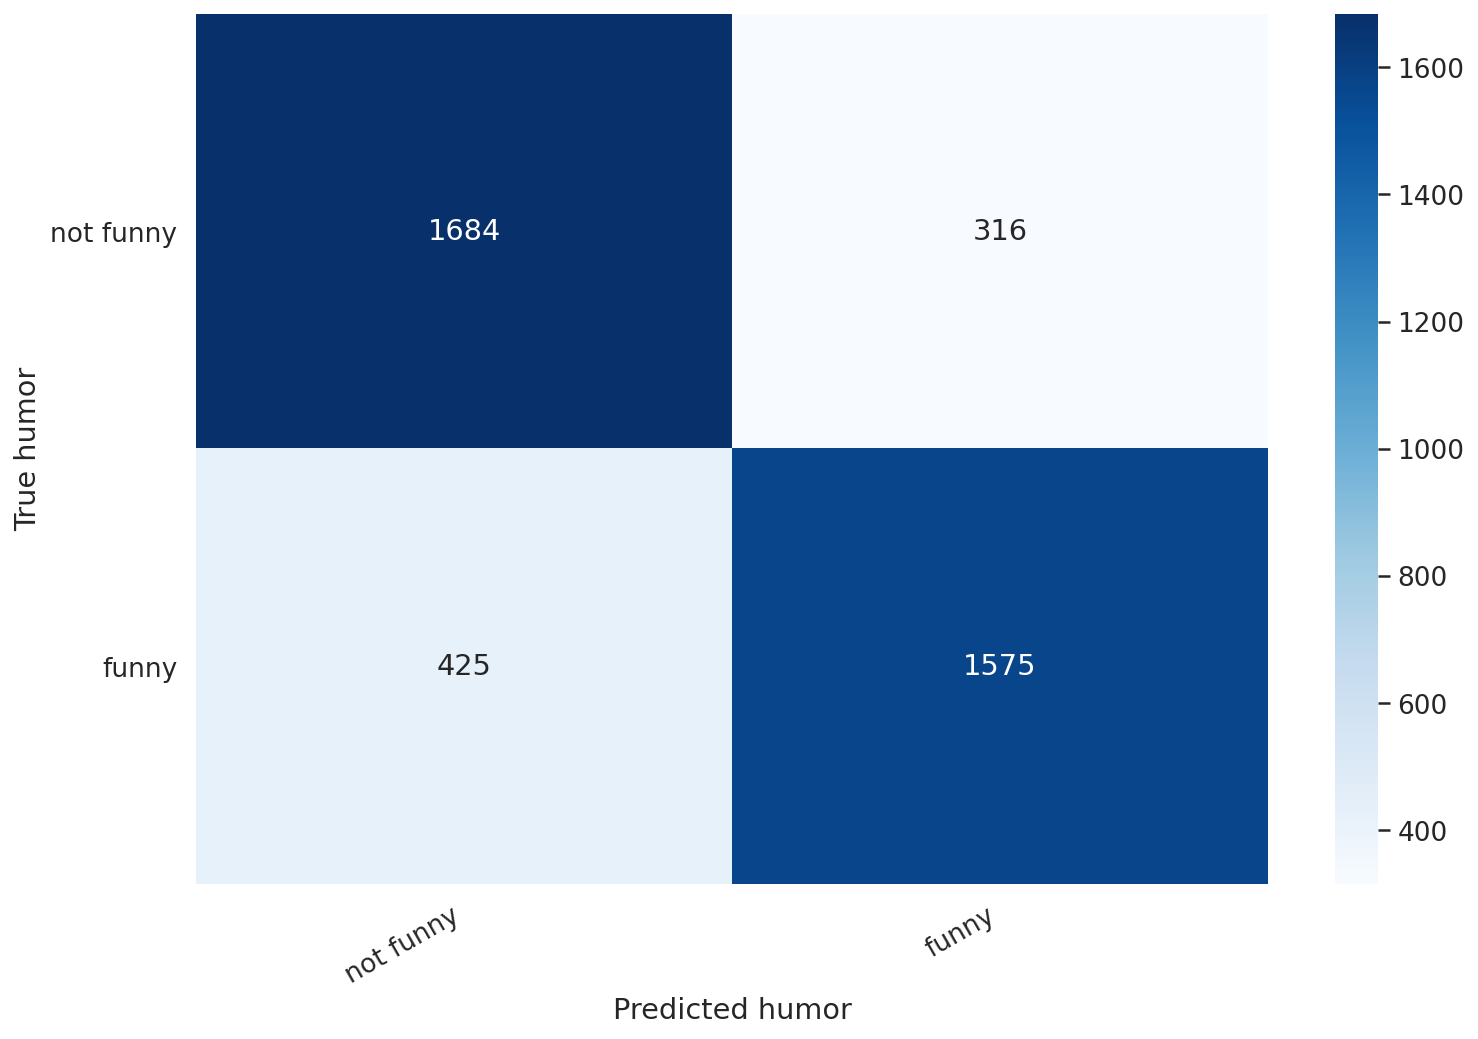

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True humor')
  plt.xlabel('Predicted humor');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True humor: {class_names[true_sentiment]}')

Magpies Modern General Store is stocked full of merchandise with
snarky comments. They also sell jewelry, artisan soaps and house
wares. Their store is listed as ....Fun. Funky. Functional. I believe
that they are all three. It truly is a great place to find something
fun and humorous for yourself or a unique gift for someone else. When
I entered the store I was not greeted by either of the two employees
standing behind the cash register. In fact they did not speak one word
to any of the people who came into the store behind me and were only
speaking to each other during my entire visit. This was a contrast to
how friendly and welcoming the store layout and merchandise made you
feel. As it turns out I was not able to find what I was looking for
but I will return to this cute little store whenever I am in Sanford.

True humor: funny


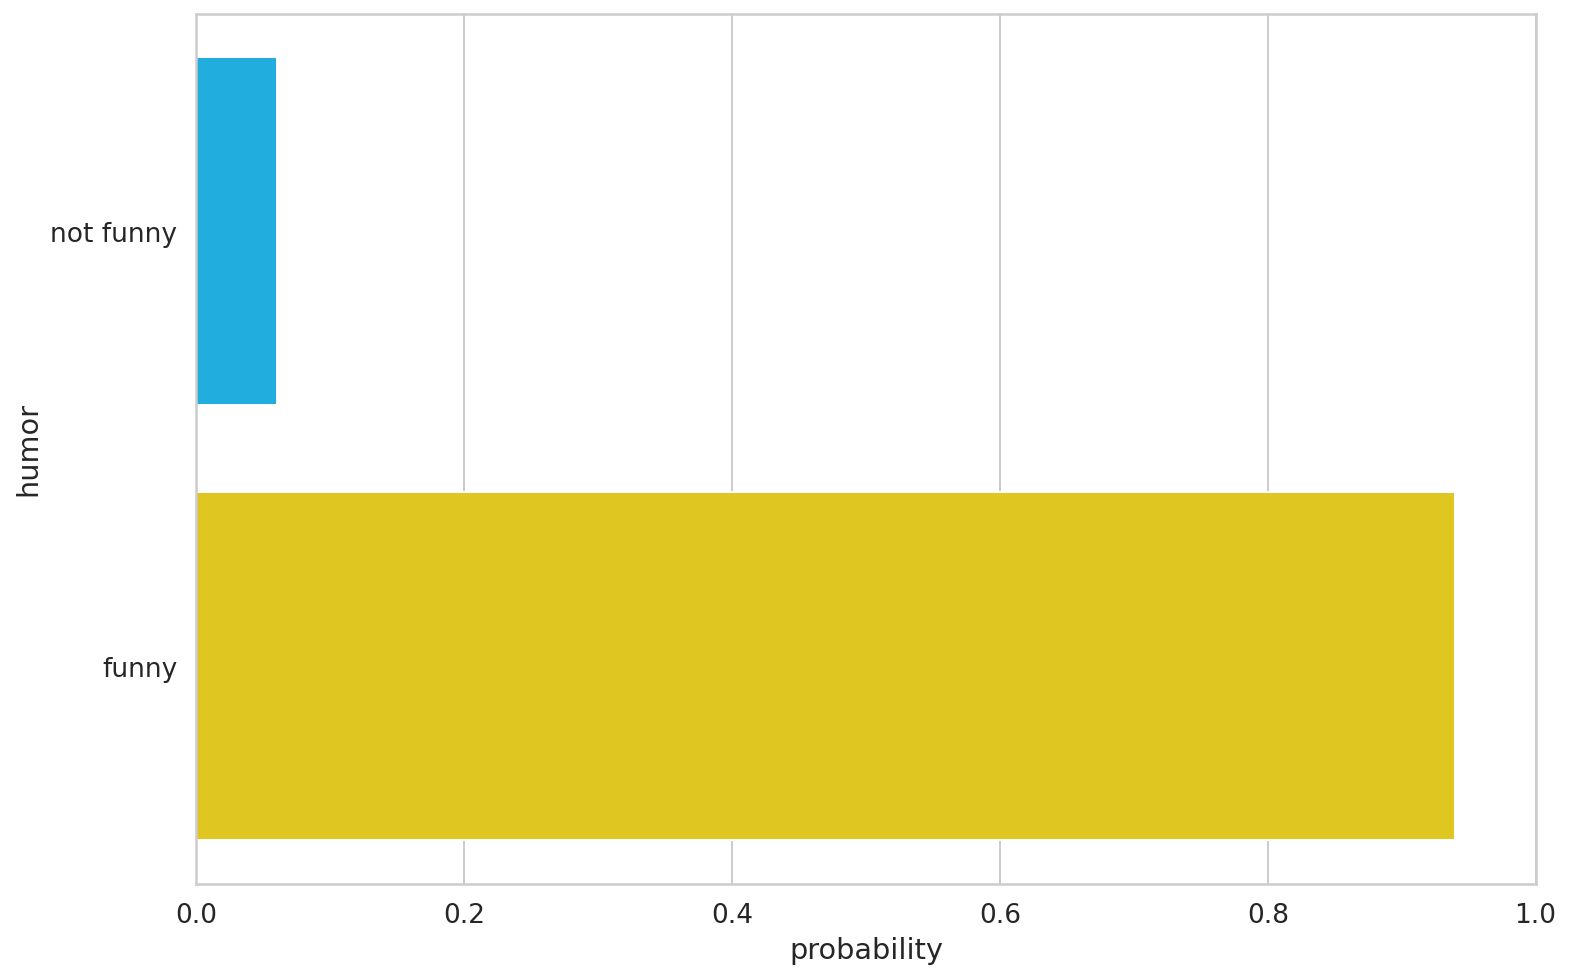

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);